In [1]:
# Std imports
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import h5py
import networkx as nx

# Scipy imports
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.integrate import trapezoid
from scipy.integrate import cumulative_trapezoid # integral discrete func
from scipy.fft import fft, fftfreq, fftshift

In [2]:
def plot_configs(ax):
    # plt.rcParams['text.usetex'] = True

    # Set bourder line
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5)

    # Tick parameters
    ax.tick_params(axis = 'both', which = 'major', length = 6, width = 1, direction = 'in', labelsize = 16)
    ax.tick_params(axis = 'both', which = 'minor', length = 4, width = 1, direction = 'in', labelsize = 16)
    ax.tick_params(labelbottom = True, labeltop = False, labelleft = True, labelright = False,
                     bottom = True, top = True, left = True, right = True)
    ax.yaxis.set_tick_params(right='on',which='both')
    return ax

## Example

In [3]:
def plot_spectrum(t_data, signal_data, t_spacing):

    # Plot config
    fig = plt.figure(figsize=(20, 3))
    ax = fig.add_subplot(131)
    ax1 = fig.add_subplot(132)
    ax2 = fig.add_subplot(133)
    
    scalMEGA = 1e6
    tickMEGA = ticker.FuncFormatter(lambda x, post: '{0:g}'.format(x/scalMEGA))

    scalmicro = 1e-6
    tickmicro = ticker.FuncFormatter(lambda x, post: '{0:g}'.format(x/scalmicro))

    # Sample rate
    fs = 1/t_spacing
    
    # FFT
    N = len(t_data)
    yf = fft(signal_data)
    xf = fftfreq(N, t_spacing)[:N//2]

    # Time domain
    plot_configs(ax)
    ax.plot(t_data, signal_data)
    ax.set_xlabel(r"Time ($\mu$s)")
    ax.set_ylabel(r"Amp")
    ax.xaxis.set_major_formatter(tickmicro)
    
    # Frequency domain
    plot_configs(ax1)
    ax1.plot(xf, 2/N * np.abs(yf[0:N//2]))
    ax1.set_xlabel(r"MHz")
    ax1.set_ylabel(r"Intensity")
    ax1.xaxis.set_major_formatter(tickMEGA)
    ax1.set_xlim(50e6, 95e6)

    # Spectrogram
    Pxx, freqs, bins, scectrogram = plt.specgram(signal_data, Fs=fs, NFFT=2048, cmap='bone')

    ax2.set_xlabel(r"Time ($\mu$s)")
    ax2.set_ylabel(r'Freq (MHz)')
    ax2.xaxis.set_major_formatter(tickmicro)
    ax2.yaxis.set_major_formatter(tickMEGA)
    ax2.set_ylim(50e6, 115e6)

    cbar = fig.colorbar(scectrogram, ax=ax2)

    

    plt.tight_layout()
    plt.show()
    return Pxx, freqs, bins

## Sine wave

In [4]:
def sine_wave_gen(init_freq, Amp_mt, init_phase, t_grab, awg_resolution):
    # Define data
    t_grab_data, t_spacing = np.linspace(0, t_grab, int(awg_resolution * t_grab), retstep=True)
    init_freq = init_freq * 1e6 # Hz
    return t_grab_data ,np.cos(init_freq * 2 * np.pi* t_grab_data), t_spacing

/var/folders/c_/_k262vjs4ds_350_jckw20h80000gn/T/ipykernel_65389/2097377952.py:39: UserWarning: Only one segment is calculated since parameter NFFT (=2048) >= signal length (=625).
  Pxx, freqs, bins, scectrogram = plt.specgram(signal_data, Fs=fs, NFFT=2048, cmap='bone')


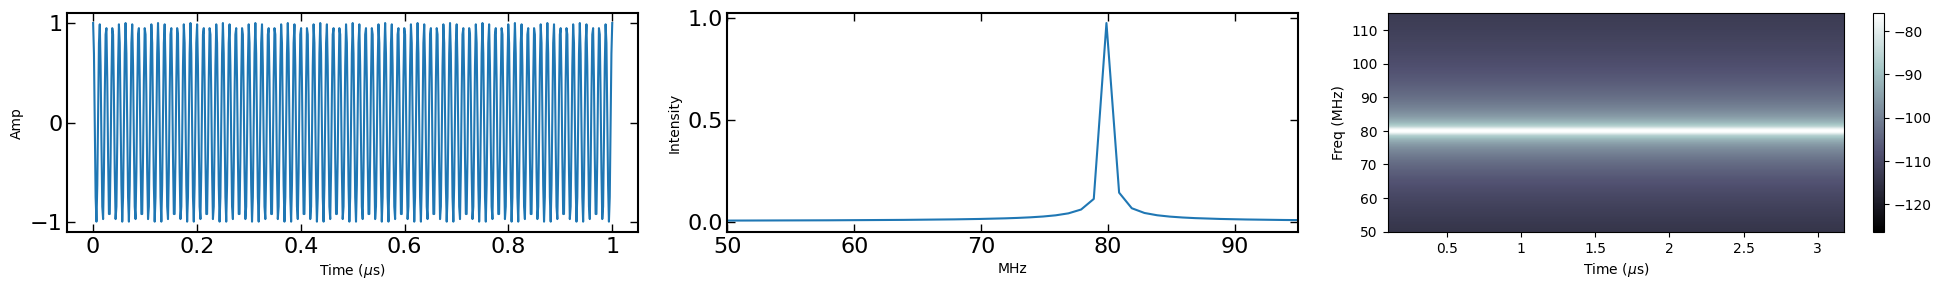

(array([[2.36806047e-13],
        [4.73659197e-13],
        [4.73799059e-13],
        ...,
        [4.68222791e-13],
        [4.68218185e-13],
        [2.34108321e-13]]),
 array([0.00000000e+00, 3.04687500e+05, 6.09375000e+05, ...,
        3.11390625e+08, 3.11695312e+08, 3.12000000e+08]),
 array([1.64102564e-06]))

In [5]:
t_data, signal_data, t_spacing = sine_wave_gen(init_freq = 80, Amp_mt = 10, init_phase = 0.0, t_grab = 1e-6, awg_resolution = 625e06)
plot_spectrum(t_data, signal_data, t_spacing)

## Grab gen

In [6]:
def grab_atom_wave_gen(init_freq, Amp_mt, init_phase, t_grab, awg_resolution):
    """
    Generating the rf signal that grab atom at the assigned location.

    Parameters
    ----------
    init_freq : float
        The atom location that we want to migrate.
        Format : [wx, wy]
    Amp_mt : float
        Trap depth of the moving tweezer.
    t_grab : float
        The time that we want to spend on grabbing sigle atom.
    """

    # Define data
    t_grab_data, t_spacing = np.linspace(0, t_grab, int(awg_resolution * t_grab), retstep=True)
    Amp_ramp_data = np.linspace(0, Amp_mt, int(awg_resolution * t_grab))
    phase = np.repeat(init_phase, len(t_grab_data))
    
    # Returning (signal_x, signal_y)
    return t_grab_data, Amp_ramp_data * np.cos(np.array(init_freq).reshape((2, 1)) * 2 * np.pi * 1e06 * t_grab_data + phase), t_spacing

def drop_atom_wave_gen(end_freq, Amp_mt, phase, t_drop, awg_resolution):
    """
    Generating the rf signal that grab atom at the assigned location.

    Parameters
    ----------
    end_freq : float
        The atom location that we want to migrate to.
    Amp_mt : float
        Trap depth of the moving tweezer.
    t_grab : float
        The time that we want to spend on grabbing sigle atom.
    """

    # Define data
    if int(awg_resolution * t_drop) < 1:
        raise ValueError('Zero sample point obtained with current awg_resolution * t_grab value (less then 1)')

    t_drop_data = np.linspace(0, t_drop, int(awg_resolution * t_drop))
    Amp_ramp_data = np.linspace(Amp_mt, 0, int(awg_resolution * t_drop))

    ## Compute the signals
    signal = Amp_ramp_data * np.cos(np.array(end_freq).reshape((2, 1)) * 2 * np.pi * 1e06 * t_drop_data + np.repeat(phase, t_drop_data.shape[0], axis=1))

    ## Normalize data
    # signal[0, :] = signal[0, :]/abs(np.max(signal[0, :]))
    # signal[1, :] = signal[1, :]/abs(np.max(signal[1, :]))

    return signal

/var/folders/c_/_k262vjs4ds_350_jckw20h80000gn/T/ipykernel_65389/2097377952.py:39: UserWarning: Only one segment is calculated since parameter NFFT (=2048) >= signal length (=625).
  Pxx, freqs, bins, scectrogram = plt.specgram(signal_data, Fs=fs, NFFT=2048, cmap='bone')


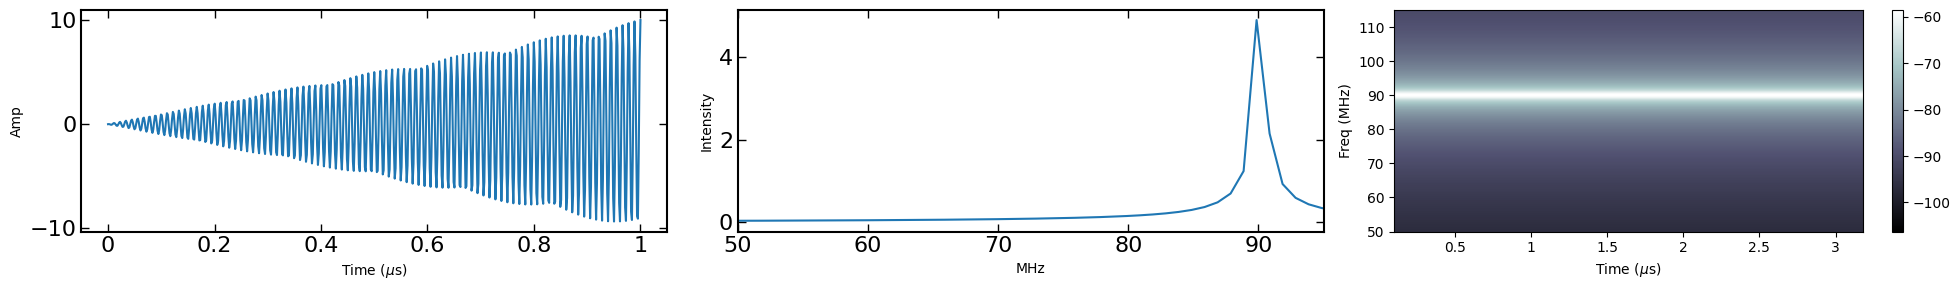

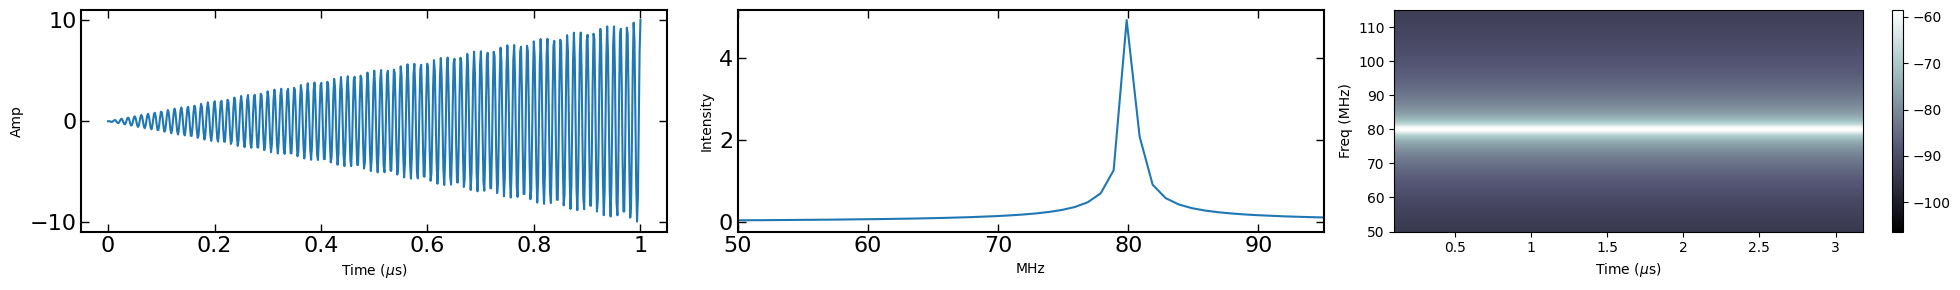

(array([[2.39265335e-11],
        [4.78577499e-11],
        [4.78718553e-11],
        ...,
        [4.69108653e-11],
        [4.69104029e-11],
        [2.34551245e-11]]),
 array([0.00000000e+00, 3.04687500e+05, 6.09375000e+05, ...,
        3.11390625e+08, 3.11695312e+08, 3.12000000e+08]),
 array([1.64102564e-06]))

In [7]:
x, y, x_spacing = grab_atom_wave_gen(init_freq = (90, 80), Amp_mt = 10, init_phase = 0.0, t_grab = 1e-6, awg_resolution = 625e06)
plot_spectrum(x, y[0], x_spacing)
plot_spectrum(x, y[1], x_spacing)

## Static signal gen

In [8]:
def static_lattice(graph, t_static, awg_resolution):
    """
    The rf signal of the static lattice.

    Note
    ----
    Need to work with the data from geometry.py
    """

    ## Get the geometry
    trap_location = np.array(list(graph.nodes))

    ## Signal time span
    t_data, t_spacing = np.linspace(0,t_static, int(awg_resolution * t_static), endpoint= False, retstep=True)

    ## Amplitude and phase data
    amplitude = 1
    phase = np.random.uniform(0, 2 * np.pi + 1e-10, trap_location.size)

    ## Calculate the signal
    data = 0
    for i, freq in enumerate(trap_location):
        data += amplitude * np.sin(freq.reshape((2, 1)) * 2 * np.pi * 1e06 * t_data + phase[i])
    normalized_factor = np.max(data)

    return t_data, data/normalized_factor, t_spacing

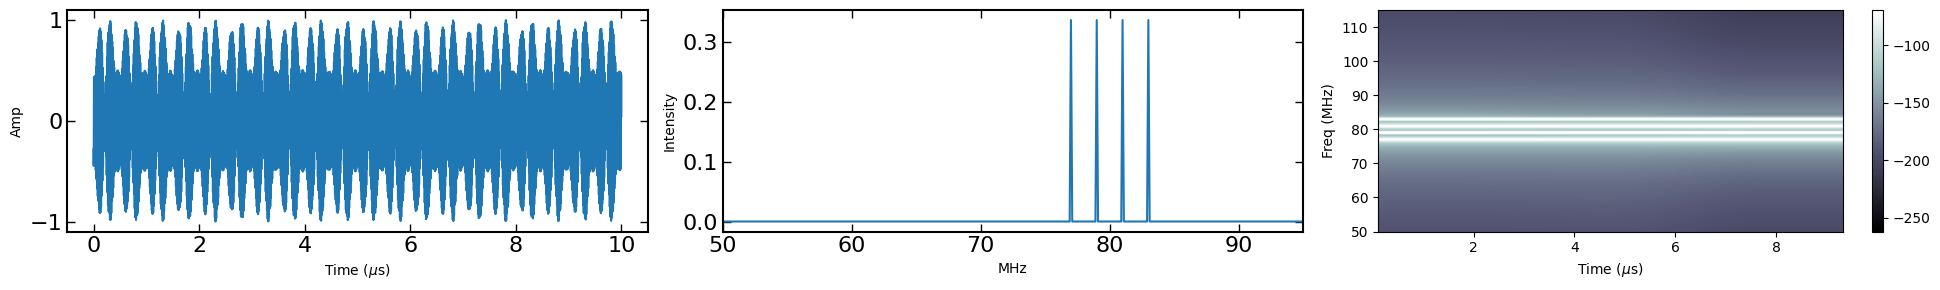

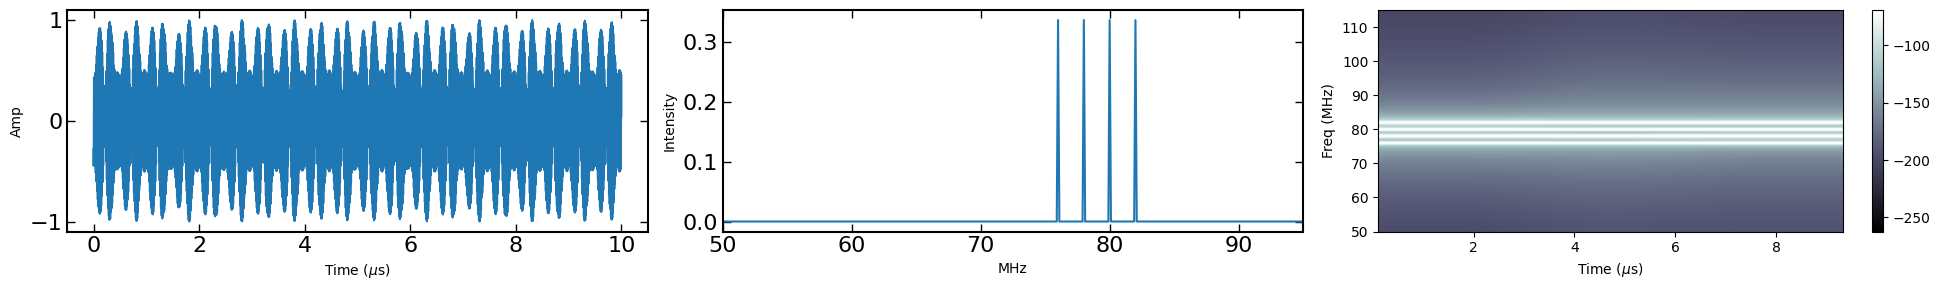

(array([[3.81007304e-25, 2.47601755e-22, 4.50000682e-23],
        [7.76143191e-25, 4.95307378e-22, 9.00808658e-23],
        [8.18475237e-25, 4.95619964e-22, 9.03221390e-23],
        ...,
        [2.42310949e-25, 2.77718679e-26, 1.16058391e-26],
        [2.42259284e-25, 2.77120195e-26, 1.16010372e-26],
        [1.21120913e-25, 1.38464527e-26, 5.79940616e-27]]),
 array([0.00000000e+00, 3.05126953e+05, 6.10253906e+05, ...,
        3.11839746e+08, 3.12144873e+08, 3.12450000e+08]),
 array([1.63866219e-06, 4.71115378e-06, 7.78364538e-06]))

In [9]:
## Define graph
freq_graph = nx.Graph()
freq_graph.add_node(tuple([77, 76]))
freq_graph.add_node(tuple([79, 78]))
freq_graph.add_node(tuple([81, 80]))
freq_graph.add_node(tuple([83, 82]))

x, y, x_spacing = static_lattice(freq_graph, t_static = 10 * 1e-6, awg_resolution = 625e6)
plot_spectrum(x, y[0], x_spacing)
plot_spectrum(x, y[1], x_spacing)

## Moving signal gen

In [10]:
def acceleration(t, t_moving, a):
    """
    Constant accleration.

    Parameters
    ----------
    t : float
        The input time data.
    t_moving : float
        The assigned moving time for this step.
    a : float
        The assigned accleration for this step.
    """
    return (1/2) * a * t**2


def decelleration(t, t_moving, a):
    """
    Constant accleration.
    Parameters
    ----------
    t : float
        The input time data.
    t_moving : float
        The assigned moving time for this step.
    a : float
        The assigned accleration for this step.
    """
    return -(1/2) * a * t**2 + a*t*t_moving - (1/4)*a*t_moving**2


def data_stack(base_data, new_data):
    """
    Stacking the next iteration of ramping data to the old ones.
    """
    # 2D case
    try: 
        return np.hstack((base_data, base_data[:, -1].reshape((2, 1)) + new_data))
    # 1D case
    except IndexError:
        return np.hstack((base_data, base_data[-1] + new_data))


def accleration_solver(init_freq, target_freq, t_moving):
    """
    The analytical solution to the accleration of this process.

    init_freq : tuple
        The initial point of the ramping process.
    target_freq : tuple
        The target point of the ramping process.
    t_moving : float
        The assigned moving time.
    """

    return 4*(target_freq.reshape((2, 1)) - init_freq.reshape((2, 1)))/(t_moving **2)


def moving_time_solver(init_freq, target_freq, ave_velocity, trap_spacing):
    """
    To be the optimal time mapping based on initial and target frequencies(positions).
    To be upgraded when we are really trapping atoms.
    Will return 1 just for now.

    Parameters
    ----------
    ave_velocity : float
        In unit of nm/microsec.
    trap_spacing : float
        In unit of micro meter.
    """
    return trap_spacing / (ave_velocity)


def freq_func_constant_ramp(freq_list, ave_velocity, trap_spacing, awg_resolution):
    """
    The constant acceleration ramping freq function itself.
    To be transform into integrals.

    Parameters
    ----------
    freq_list : list
        The atom position we want to scan through.
    awg_resolution : float
        The resolution of the awg card.
    """
    i = 0
    while i < len(freq_list) - 1:
        # Extract position data
        init_freq = np.asarray(freq_list[i]) * 2 * np.pi * 1e06
        target_freq = np.asarray(freq_list[i+1]) * 2 * np.pi * 1e06

        # Compute the optimum moving time and accleration in this iteration
        t_moving = moving_time_solver(init_freq, target_freq, ave_velocity, trap_spacing)
        a = accleration_solver(init_freq, target_freq, t_moving)

        # Generating the time data for this iteration
        # t_data_accleration and t_data_deccleration should be fixed in each iteration
        t_data_accleration, t_spacing = np.linspace(0, t_moving/2, int(awg_resolution * t_moving/2), endpoint=False, retstep=True)
        t_data_deccleration = np.linspace(t_moving/2, t_moving, int(awg_resolution * t_moving/2), endpoint=False)
        
        # Generating the raming data for this iteration
        # For the first iteration, there is no data to stack on.
        if i == 0:
            t_data = np.append(t_data_accleration, t_data_deccleration)
            data = np.hstack((acceleration(t_data_accleration, t_moving, a), decelleration(t_data_deccleration, t_moving, a)))
        # For the i>0 iteration, we will need to stack the data on previous one and add some offsets.
        else:
            t_data = data_stack(base_data = t_data, new_data = np.append(t_data_accleration, t_data_deccleration) + t_spacing)
            #TODO: by doing this, we might waste time on the boundary points, since there are duplicated data points on the connections
            data = data_stack(base_data = data, new_data = np.hstack((acceleration(t_data_accleration, t_moving, a), decelleration(t_data_deccleration, t_moving, a))))
        i+=1
    
    return t_data, data, t_spacing

def cumulative_trapezoid2D(data, t_data, initial = 0):
    """
    The 2D version of scipy cumulative_trapezoid integration.

    Note
    ----
    The initial argument will give the set the initial response to x[0] to be a certain value.
    Making the output data the same length as t_data.
    """
    return np.vstack((cumulative_trapezoid(data[0], t_data, initial = initial), cumulative_trapezoid(data[1], t_data, initial = initial)))

def moving_tweezer_ramping(freq_list, awg_resolution):
    """
    Taking the frequency function and generate its integral based on interpolation.
    
    Parameters
    ----------
    freq_list : list
        The atom position we want to scan through.
    awg_resolution : float
        The resolution of the awg card.

    Notes
    -----
    For the integration of freq function, there are three possible directions.
    
    1. Use InterpolatedUnivariateSpline to get the freq function and then integral.
    2. Use scipy.integral.cumulative_trapezoid to get the integral
    3. Work on the analytical solution of that integral if neccessary.

    All above will give the correct restult and the benchmarks for ramping 
    between two points are like,

    ramp data cal time = 0.06514325000000554s
    InterpolatedUnivariateSplin cal time = 0.04459370900002568s
    cumulative_trapezoid cal time = 0.004300666999995428s.

    Another thing no notice is that if we are sampling with 625 MHz,
    then even freq function cal time will be forever. Luckily, the known
    tweezer moving time is in micro sec scale, so we don't need to worry about
    this issue. (Just for now)
    """
    # Generate the freq ramping data based on 
    # constant accleration
    #ramp_start = time.perf_counter()
    t_data, data = freq_func_constant_ramp(freq_list, awg_resolution)
    #ramp_end = time.perf_counter()

    # Since the data points might not be a trivial function for one to integrate
    # we use scipy model to help us better integrate the freq function with some 
    # numerical techniques
    
    # Interpolation method
    # interpolate_start = time.perf_counter()
    # interpolated_freq_function = InterpolatedUnivariateSpline(t_data, data, k=1)
    # integral_val = interpolated_freq_function.integral(t_data[0], t_data[-1])
    # interpolate_end = time.perf_counter()

    # Direct integration, will return the integration among all discrete data
    #inter_start = time.perf_counter()
    integral_val = trapezoid(data, t_data)
    # For cumulated data, we use cumulative_trapezoid
    #inter_end = time.perf_counter()

    # print(f'ramp data cal time = {ramp_end - ramp_start}')
    # print(f'interpolation cal time = {interpolate_end - interpolate_start}')
    # print(f'integral cal time = {inter_end - inter_start}')

    return integral_val

In [11]:
def move_atom_wave_gen(freq_list, Amp_mt, phase, ave_velocity, trap_spacing, awg_resolution = 625e06):
    """
    Generating the rf signal that move atom from one location to another.
    
    Parameters
    ----------
    freq_list : list
        The atom position (rf frequencies) that we want to ramp through.
        Format : [[wx, wy]_i]
    Amp_mt : float
        The amplitude of the moving tweezer. Typically 10 time larger than the static traps.
    phase : float
        The phase data of the initial atom position.
    awg_resolution : float
        The resolution of the AWG card. Typically 625 MHz.
    """
    # First get the ramping freq function (discrete data points)
    t_data, data, t_spacing = freq_func_constant_ramp(freq_list, ave_velocity, trap_spacing, awg_resolution)

    # Calculate the rf signals for moving tweezers
    # cumulative_trapezoid will return the "cumulated" integral of time t
    return t_data, Amp_mt * np.cos(np.array(freq_list[0]).reshape((2, 1)) * 2 * np.pi * 1e06 * t_data + phase + cumulative_trapezoid2D(data, t_data, initial=0)), t_spacing
    

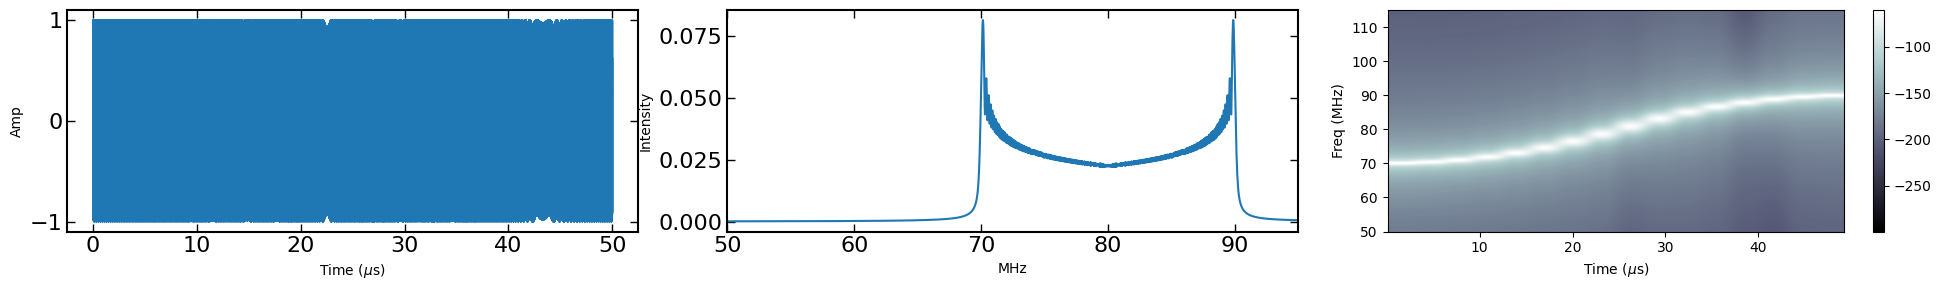

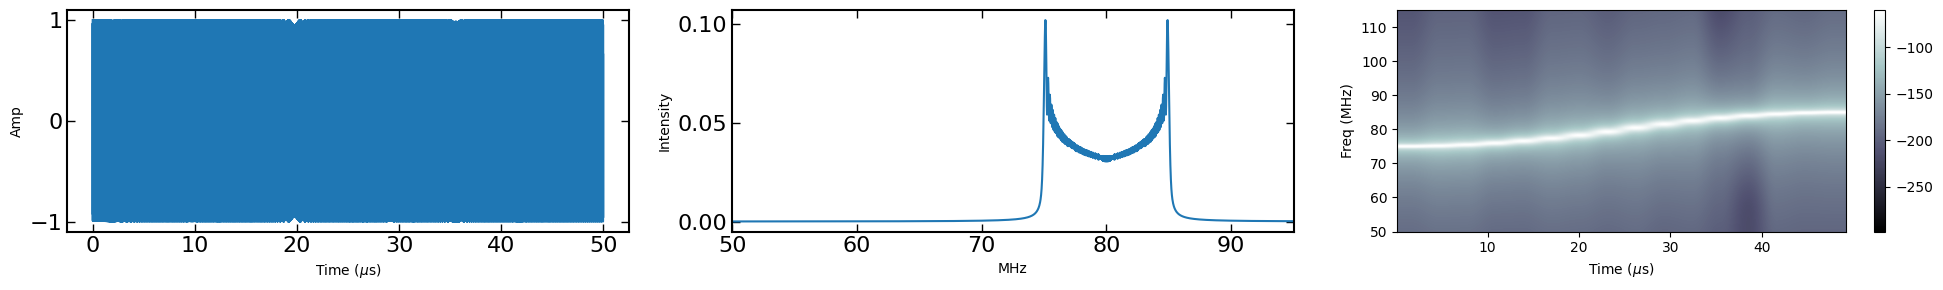

In [12]:
freq_list = [[70, 75], [90, 85]]
Amp_mt = 1
phase = 0
ave_velocity = 1e-1
trap_spacing = 5e-6
t_data, signal_data, t_spacing = move_atom_wave_gen(freq_list, Amp_mt, phase, ave_velocity, trap_spacing, awg_resolution = 625e06)
xPxx, xfreqs, xbins = plot_spectrum(t_data, signal_data[0], t_spacing)
yPxx, yfreqs, ybins = plot_spectrum(t_data, signal_data[1], t_spacing)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (3, 2) + inhomogeneous part.

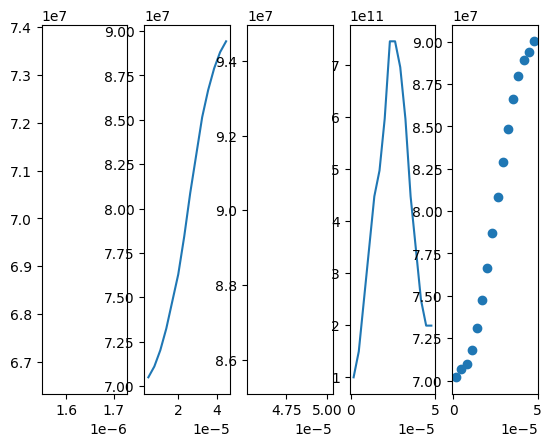

In [13]:
def compress(x_freq_start, x_freq_end, Pxx, freqs, bins):
	# generate required data
	t_x_freq = abs(x_freq_start - x_freq_end)
	t_x_freq_limit = 0.01 * t_x_freq

	max_freqs = []
	start_slow = []
	middle_fast = []
	end_slow = []

	for j in range(Pxx.shape[1]):
		# print(bins[j],freqs[np.argmax(Pxx[:,j])])
		max_freqs.append(freqs[np.argmax(Pxx[:,j])])

	start_max_freq = max_freqs[0]
	end_max_freq = max_freqs[len(max_freqs)-1]
	for j in range(Pxx.shape[1]):
		if abs(max_freqs[j]-start_max_freq) < t_x_freq_limit:
			start_slow.append(max_freqs[j])
		elif abs(max_freqs[j]-end_max_freq) < t_x_freq_limit:
			end_slow.append(max_freqs[j])
		else:
			middle_fast.append(max_freqs[j])			

	plt.subplot(1,5,1)
	plt.plot(bins[0:len(start_slow)], start_slow)
	derivative = np.gradient(max_freqs, bins)

	plt.subplot(1,5,2)
	plt.plot(bins[len(start_slow):len(start_slow)+len(middle_fast)],middle_fast)
	plt.subplot(1,5,3)
	plt.plot(bins[len(start_slow)+len(middle_fast):len(start_slow)+len(middle_fast)+len(end_slow)],end_slow)
	plt.subplot(1,5,4)
	plt.plot(bins,derivative)
	# fit the graph
	max_freqs_fit = []
	# slow changing phase in the begining
	coeff_slow = np.polyfit(bins[0:len(start_slow)], start_slow,0)
	poly_slow = np.poly1d(coeff_slow)
	max_freqs_fit = np.concatenate([max_freqs_fit,poly_slow(bins[0:len(start_slow)])])

	# fast changing phase in the middle
	coeff_fast = np.polyfit(bins[len(start_slow):len(start_slow)+len(middle_fast)],middle_fast,3)
	poly = np.poly1d(coeff_fast)
	max_freqs_fit = np.concatenate([max_freqs_fit,poly(bins[len(start_slow):len(start_slow)+len(middle_fast)])])

	# slow changing phase in the end
	coeff_slow_end = np.polyfit(bins[len(start_slow)+len(middle_fast):len(start_slow)+len(middle_fast)+len(end_slow)],end_slow,0)
	poly = np.poly1d(coeff_slow_end)
	max_freqs_fit = np.concatenate([max_freqs_fit,poly(bins[len(start_slow)+len(middle_fast):len(start_slow)+len(middle_fast)+len(end_slow)])])
	plt.subplot(1,5,5)
	plt.scatter(bins,max_freqs_fit)
	return np.array([[len(start_slow),coeff_slow],[len(middle_fast), coeff_fast], [len(end_slow), coeff_slow_end]])

compress(freq_list[0][0],freq_list[1][0], xPxx, xfreqs, xbins)
#compress(freq_list[0][1],freq_list[1][1],yPxx,yfreqs, ybins)

### Parallel Tweezers

In [ ]:
def cal_parallel_tweezer_wave_gen(freq_path, awg_resolution, grab_drop_time, ave_velocity, trap_spacing, save_folder = "./Experiments/"):
    """
    Generating the rf signal that drive multipe tweezers to the assigned location.

    Parameters
    ----------
    freq_path : list
        The path data that assign tweezer locations.
    lattice : str
        The classification of the lattice.
    save_folder : str
        Where the precalculated data file located.

    Notes
    -----
    The formation of freq_path is different than single tweezer. 
    Should be in the form of freq_path[row][move][trap]

    For FIFO mode in practice, maybe we should send new rf signal to the card every time we 
    complete the calculation for each row, instead of calculating the entire rearranging process.
    
    But for a template, we just send the complete rearranging signals to the card.
    Possible control sequence:
        Reservior moving -> target moving layers ...

    # TODO: This is a template
    """
    
    ## Some general parameters
    ## AWG card related
    
    ## Trap depth
    Amp_static = 1 # micro kelvin
    Amp_mt = 0.1 * Amp_static
    
    ## Trap related
    # Grap/Drop time
    t_grab = grab_drop_time * 1e-6 # sec
    t_drop = grab_drop_time * 1e-6 # sec
    t_static = 1e3 * 1e-6 # sec

    signal = np.zeros((2, 1))
    
    ## Calculate the moving data for each row
    for row in freq_path:
        move_signal = 0
        for move in row:
            freq_list = [move[0], move[-1]]
            phase_num = np.random.uniform(0, 2*np.pi + 1e-11)
            phase = np.array([phase_num, phase_num]).reshape(2, 1)
            ## Each move signal should be the same length, the same time data.
            ## TODO: Need to compute the moving time
            # grab_signal = grab_atom_wave_gen(freq_list[0], Amp_mt, phase, t_grab, awg_resolution)
            # drop_signal = drop_atom_wave_gen(freq_list[-1], Amp_mt, phase, t_drop, awg_resolution)
            t_data, moving_signal, t_spacing= move_atom_wave_gen(freq_list, Amp_mt, phase, ave_velocity, trap_spacing, awg_resolution = 625e06)
            
            ## Stack all three types of signals that form one move signal
            move_signal += moving_signal# np.hstack((grab_signal, moving_signal, drop_signal))
        
        ## Append the the row signal to the total signal
        signal = np.hstack((signal, move_signal[:, 1:])) ## Get rid of np.zeros((2, 1))

    ## Might need to normalize
    signal[0, :] = signal[0, :]/np.max(signal[0, :])
    signal[1, :] = signal[1, :]/np.max(signal[1, :])

    return t_data, signal, t_spacing ## Get rid of np.zeros((2, 1))

#### Compress Parallel Tweeers

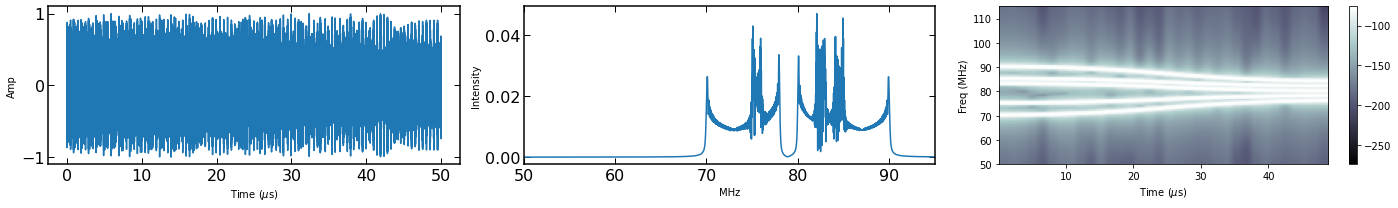

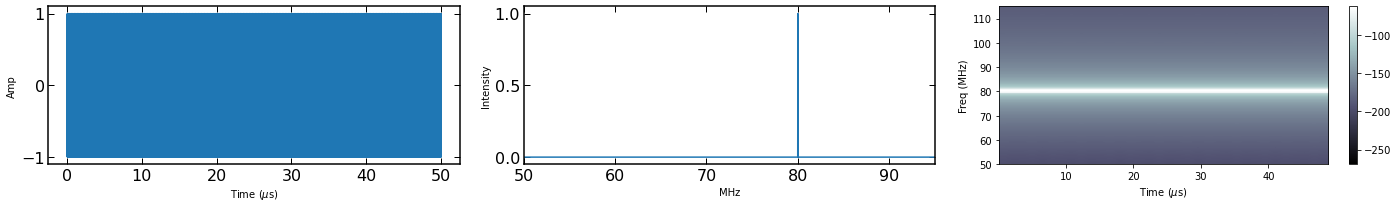

In [ ]:
awg_resolution = 625e06
grab_drop_time = 1e-6
ave_velocity = 1e-1
trap_spacing = 5e-6
freq_path = [[[[70, 80], [76, 80]], [[75, 80], [78, 80]], [[83, 80], [80, 80]], [[85, 80], [82, 80]], [[90, 80], [84, 80]]]] 
t_data, signal_data, t_spacing = cal_parallel_tweezer_wave_gen(freq_path, awg_resolution, grab_drop_time, ave_velocity, trap_spacing, save_folder = "./Experiments/") 
plot_spectrum(t_data, signal_data[0], t_spacing)
plot_spectrum(t_data, signal_data[1], t_spacing)

#### Shuttle Parallel Tweezers

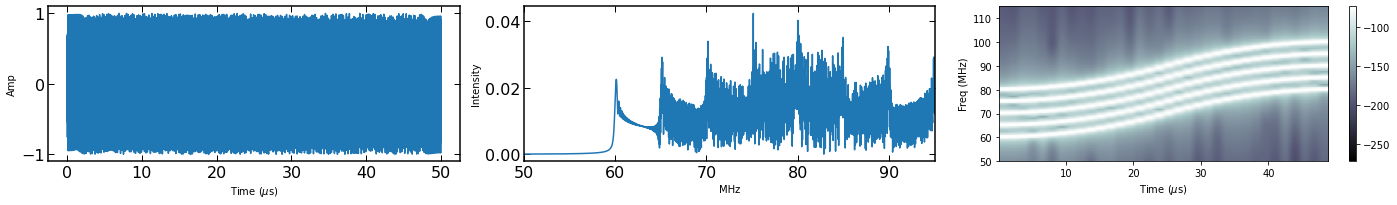

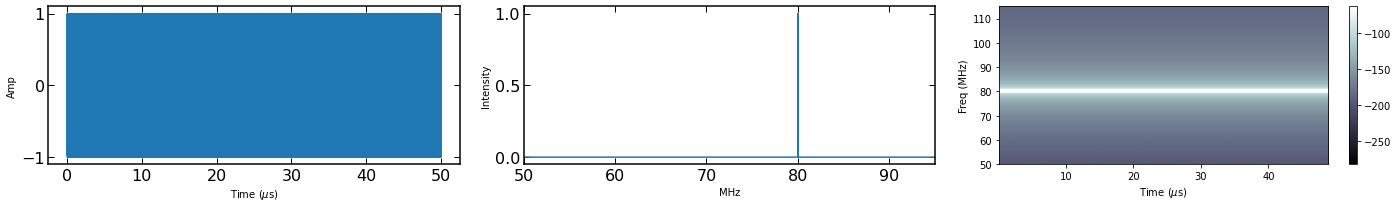

In [ ]:
awg_resolution = 625e06
grab_drop_time = 1e-6
ave_velocity = 1e-1
trap_spacing = 5e-6
freq_path = [[[[60, 80], [80, 80]], [[65, 80], [85, 80]], [[70, 80], [90, 80]], [[75, 80], [95, 80]], [[80, 80], [100, 80]]]] 
t_data, signal_data, t_spacing = cal_parallel_tweezer_wave_gen(freq_path, awg_resolution, grab_drop_time, ave_velocity, trap_spacing, save_folder = "./Experiments/") 
plot_spectrum(t_data, signal_data[0], t_spacing)
plot_spectrum(t_data, signal_data[1], t_spacing)

## Data from experiment

ValueError: x and y must have same first dimension, but have shapes (62499999,) and (3125,)

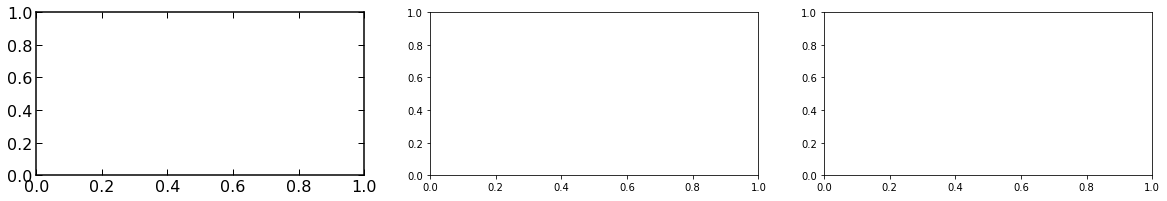

In [ ]:
# Not comment out for clean
precal_data = h5py.File(f'../../../../Experiments/AWG/precal_signals/MovingTweezerSignal_rectangular_20231124_104732.hdf5', 'r')
awg_resolution = 625e06# 625e3
grab_drop_time = 1e5 * 1e-6
ave_velocity = 75 
trap_spacing = 15e-07

for signal_mode in ["grab", "drop", "move"]:
    signals = list(precal_data[signal_mode]["signal"]) # signals is a 2xt np.array

    if signal_mode == "grab" or signal_mode == "drop":
        t, t_spacing = np.linspace(0, grab_drop_time, int(awg_resolution * grab_drop_time), retstep=True)

    elif signal_mode == "move":
        freq_list = [[85, 85], [90, 85]]
        t, d, t_spacing = freq_func_constant_ramp(freq_list, ave_velocity, trap_spacing, awg_resolution)
        
    for signal in (signals):
        signal_dataset = precal_data[signal_mode]["signal"][signal]
        plot_spectrum(t, signal_dataset[0], t_spacing)